# ML Homework2 

2.1 Use each of the following algorithms to train a classifier. If the algorithm requires tuning a
parameter, use stratified 5-fold cross validation. For each algorithm, report the out-of-sample
AUC.
(a) Logistic Regression
(b) Logistic Regression with L1-regularization
(c) Logistic Regression with L2-regularization
(d) Decision Tree
Hint: For parts (b) and (c), the LogisticRegressionCV() function may be helpful. Make
sure to import it the same way you import LogisticRegression. A sample usage would be
the following:
LogisticRegressionCV(penalty=‘l1’,Cs=[1,10,100],cv=5,solver=‘liblinear’)
This says to employ an L1 penalty, to try the tuning parameters 1,10, and 100, to use 5-fold
(stratified) cross-validation, and to solve with a solver called “liblinear” (just take this last
part for granted).

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix

In [73]:
file_path = 'framingham.csv'
framingham_data = pd.read_csv(file_path)

In [74]:
# exploring the data to ensure it's clean and prepared for the next step
framingham_data.info() # there are no nulls in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3658 entries, 0 to 3657
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Male             3658 non-null   int64  
 1   Age              3658 non-null   int64  
 2   Education        3658 non-null   object 
 3   CurrentSmoker    3658 non-null   int64  
 4   CigsPerDay       3658 non-null   int64  
 5   BPMeds           3658 non-null   int64  
 6   PrevalentStroke  3658 non-null   int64  
 7   PrevalentHyp     3658 non-null   int64  
 8   Diabetes         3658 non-null   int64  
 9   TotChol          3658 non-null   int64  
 10  SysBP            3658 non-null   float64
 11  DiaBP            3658 non-null   float64
 12  BMI              3658 non-null   float64
 13  HeartRate        3658 non-null   int64  
 14  Glucose          3658 non-null   int64  
 15  TenYearCHD       3658 non-null   int64  
dtypes: float64(3), int64(12), object(1)
memory usage: 457.4+ KB


In [75]:
framingham_data.head()

,Male,Age,Education,CurrentSmoker,CigsPerDay,BPMeds,PrevalentStroke,PrevalentHyp,Diabetes,TotChol,SysBP,DiaBP,BMI,HeartRate,Glucose,TenYearCHD
0,1,39,College,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
1,0,46,High school/GED,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
2,1,48,Some high school,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
3,0,61,Some college/vocational school,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
4,0,46,Some college/vocational school,1,23,0,0,0,0,285,130.0,84.0,23.10,85,85,0


All the columns in the dataframe are either numerical or boolean except 'Education'. Henece, would be applying one-hot encoding in the following step.

In [76]:
print(framingham_data['Education'].unique())

['College' 'High school/GED' 'Some high school'
 'Some college/vocational school']


In [77]:
# One-hot encoding for categorical variable Education
prepared_data = pd.get_dummies(framingham_data, drop_first=True)
prepared_data.info()
# the category 'College' is taken as the base category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3658 entries, 0 to 3657
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Male                                      3658 non-null   int64  
 1   Age                                       3658 non-null   int64  
 2   CurrentSmoker                             3658 non-null   int64  
 3   CigsPerDay                                3658 non-null   int64  
 4   BPMeds                                    3658 non-null   int64  
 5   PrevalentStroke                           3658 non-null   int64  
 6   PrevalentHyp                              3658 non-null   int64  
 7   Diabetes                                  3658 non-null   int64  
 8   TotChol                                   3658 non-null   int64  
 9   SysBP                                     3658 non-null   float64
 10  DiaBP                               

In [78]:
# Split data into features and target
X = prepared_data.drop('TenYearCHD', axis=1)
y = prepared_data['TenYearCHD']

In [79]:
#Standardization
X = (X - X.mean(numeric_only = True))/X.std(numeric_only = True)
X.head()

,Male,Age,CurrentSmoker,CigsPerDay,BPMeds,PrevalentStroke,PrevalentHyp,Diabetes,TotChol,SysBP,DiaBP,BMI,HeartRate,Glucose,Education_High school/GED,Education_Some college/vocational school,Education_Some high school
0,1.119602,-1.232411,-0.978230,-0.757065,-0.176877,-0.075976,-0.672768,-0.166761,-0.948978,-1.193947,-1.078733,0.292010,0.356321,-0.203016,-0.656098,-0.446419,-0.845910
1,-0.892931,-0.414848,-0.978230,-0.757065,-0.176877,-0.075976,-0.672768,-0.166761,0.298253,-0.514811,-0.160096,0.724911,1.608249,-0.244850,1.523745,-0.446419,-0.845910
2,1.119602,-0.181259,1.021975,0.920563,-0.176877,-0.075976,-0.672768,-0.166761,0.184868,-0.220518,-0.243609,-0.108914,-0.060988,-0.495852,-0.656098,-0.446419,1.181835
3,-0.892931,1.337073,1.021975,1.759377,-0.176877,-0.075976,1.485991,-0.166761,-0.268670,0.798187,1.009079,0.688016,-0.895606,0.884661,-0.656098,2.239437,-0.845910
4,-0.892931,-0.414848,1.021975,1.172207,-0.176877,-0.075976,-0.672768,-0.166761,1.091946,-0.107329,0.090441,-0.659878,0.773630,0.131654,-0.656098,2.239437,-0.845910


In [80]:
# Splitting the data into training and test sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Checking if the stratification worked 
# (the printed numbers should be approximately equal)
print(y_train.mean())
print(y_test.mean())

0.15234375
0.15209471766848817


The split of the data is into features (X) and target (y), with the target variable being 'TenYearCHD'. It is likely that the target variable represents a 10-year risk of coronary heart disease. Next, a 70/30 split of the data is made into training and test sets. To guarantee that the training and test sets have roughly the same proportion of samples from each target class as the entire set, stratification is used. After printing the target variable's mean values for the training and test sets, the results are 0.15234375 for the training set and 0.15209471716684817 for the test set. The closeness of these numbers indicates that the stratification was successful in keeping the target variable's share in both sets roughly equal.

In [81]:
# (a) Logistic Regression
LR = LogisticRegression(max_iter=10000, random_state=42)
LR.fit(X_train, y_train)

y_pred_proba_LR = LR.predict_proba(X_test)
# using y_pred_proba_LR[:,1] to capture just the predicted probabilities of y=1
# out-of-sample AUC
auc_LR = roc_auc_score(y_test, y_pred_proba_LR[:,1])
print(f"Logistic Regression out-of-sample AUC: {auc_LR:.4f}")

Logistic Regression out-of-sample AUC: 0.7478


In [82]:
# (b) Logistic Regression with L1-regularization
LR_l1 = LogisticRegressionCV(penalty='l1', Cs=[1, 10, 100], cv=5, solver='liblinear', random_state=42)
LR_l1.fit(X_train, y_train)

y_pred_proba_LR_l1 = LR_l1.predict_proba(X_test)
# out-of-sample AUC
auc_LR_l1 = roc_auc_score(y_test, y_pred_proba_LR_l1[:, 1])
print(f"Logistic Regression (with L1) out-of-sample AUC: {auc_LR_l1:.4f}")

Logistic Regression (with L1) out-of-sample AUC: 0.7479


In [83]:
# (c) Logistic Regression with L2-regularization
LR_l2 = LogisticRegressionCV(penalty='l2', Cs=[1, 10, 100], cv=5, solver='liblinear', random_state=42)
LR_l2.fit(X_train, y_train)

y_pred_proba_LR_l2 = LR_l2.predict_proba(X_test)
# out-of-sample AUC
auc_LR_l2 = roc_auc_score(y_test, y_pred_proba_LR_l2[:, 1])
print(f"Logistic Regression (with L2) out-of-sample AUC: {auc_LR_l2:.4f}")

Logistic Regression (with L2) out-of-sample AUC: 0.7479


In [84]:
# (d) Decision Tree
dec_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                  param_grid={'min_samples_split': range(10,501,10)},
                  scoring='roc_auc', cv=5)
dec_tree.fit(X_train, y_train)

y_pred_proba_dec_tree = dec_tree.predict_proba(X_test)
# out-of-sample AUC
auc_dec_tree = roc_auc_score(y_test, y_pred_proba_dec_tree[:, 1])
clf_dt = dec_tree.best_estimator_
print(f"Decision Tree out-of-sample AUC: {auc_dec_tree:.4f}")

Decision Tree out-of-sample AUC: 0.6882


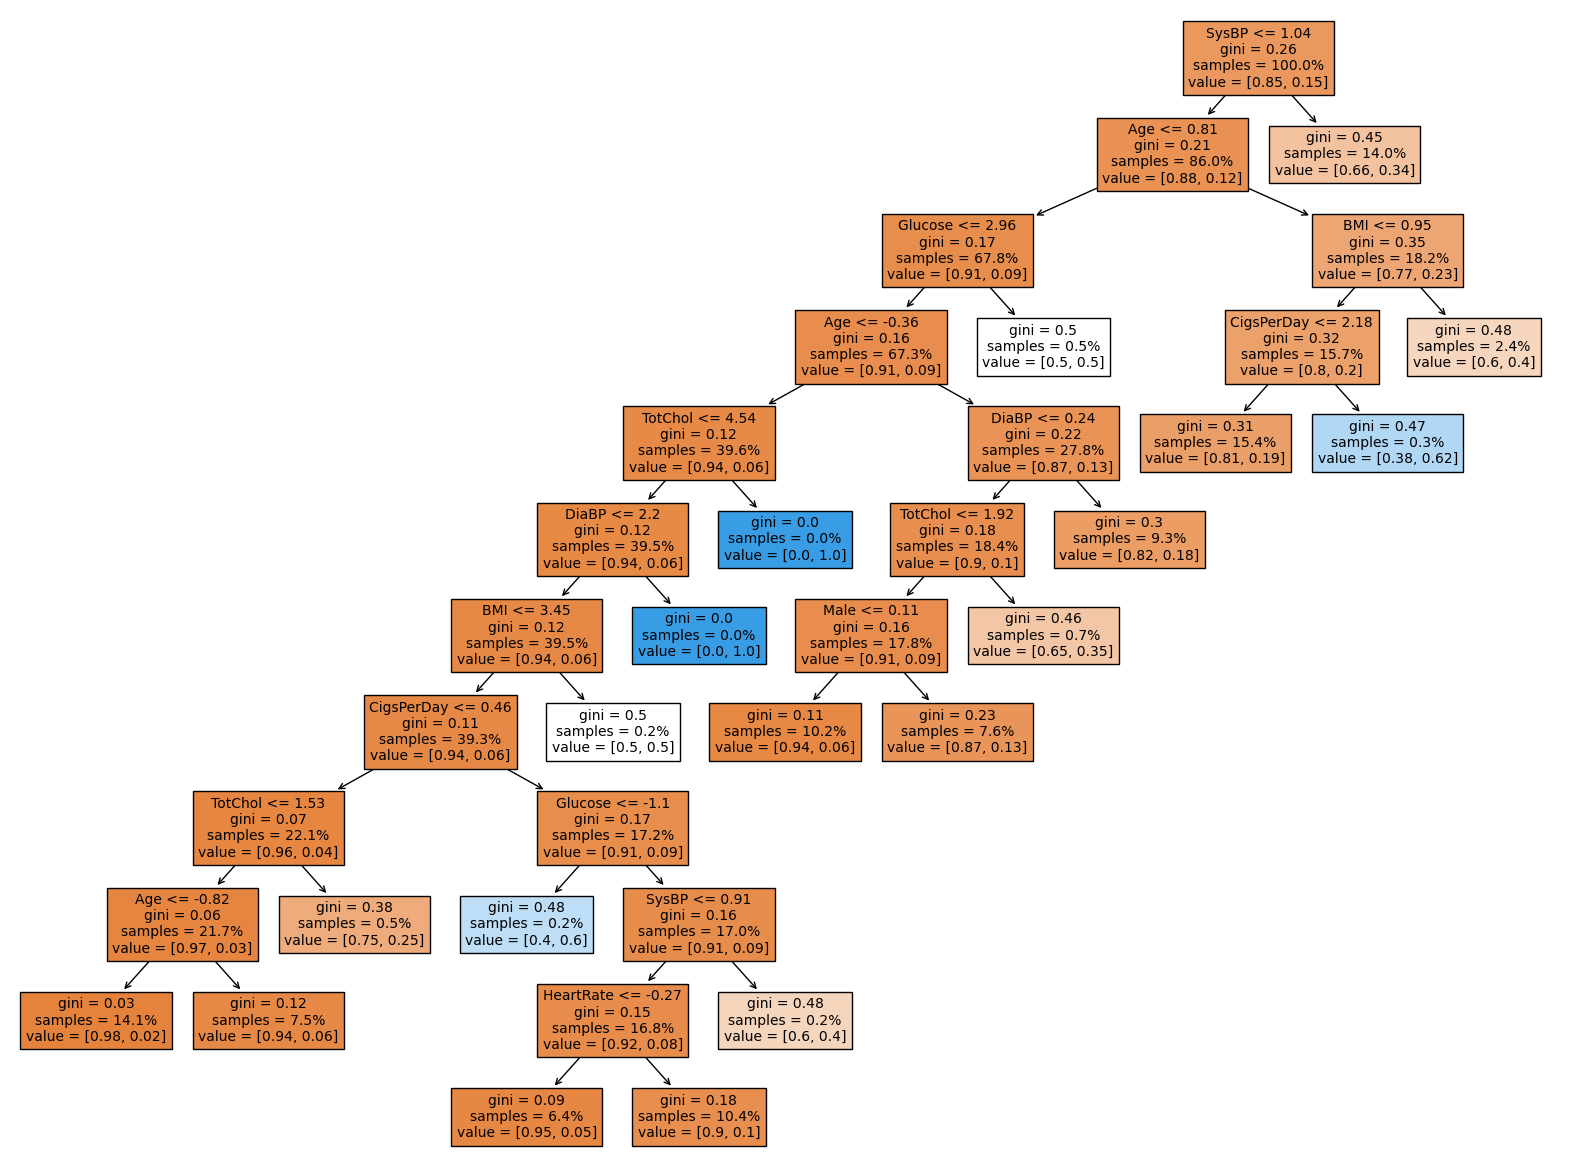

In [85]:
plt.rcParams["figure.figsize"] = (20,15)
plot_tree(clf_dt, feature_names=list(X.columns), filled=True, fontsize=10, proportion=True, precision=2)
plt.show()

A note: The Logistic Regression models with higher out-of-sample AUCs outperform Decision Tree model. These models have the higher AUC scores, indicating their ability to effectively discriminate between the classes in the dataset.

2.2 Build a simple decision tree. By “simple” we mean a prediction should be made after at
most three queries. Afterward, provide the following for your classifier:
(a) A visual depiction of the tree
(b) Its out-of-sample AUC
(c) Its out-of-sample ROC plot
(d) The highest achievable True Positive Rate if we require a True Negative Rate of at least
60%.

In [86]:
# Train a simple Decision Tree
simple_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
simple_tree.fit(X_train, y_train)

# Predict probabilities for y=1 for the test set
y_pred_proba = simple_tree.predict_proba(X_test)[:, 1]

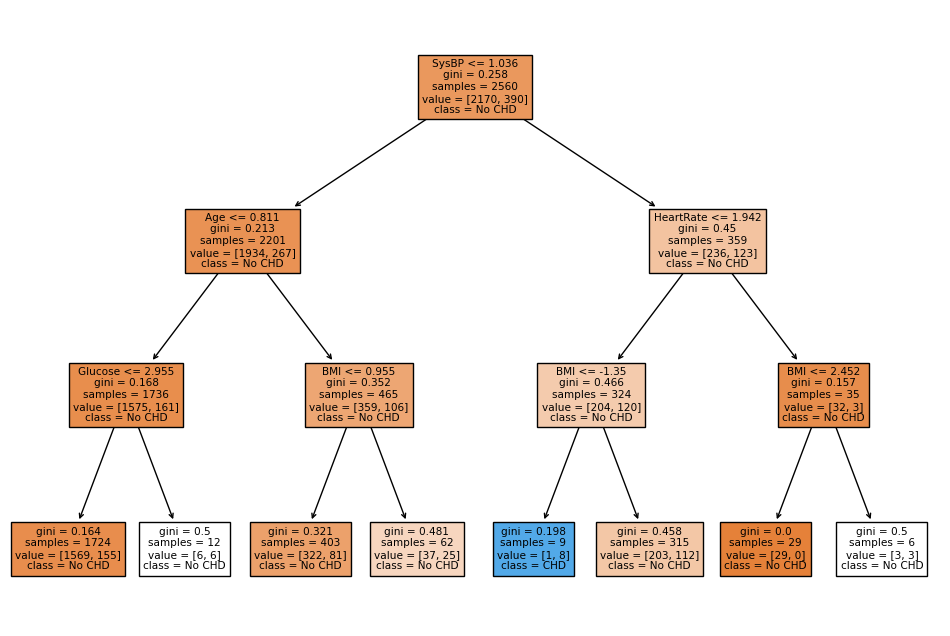

In [87]:
# (a) Visual depiction of the tree
plt.figure(figsize=(12, 8))
plot_tree(simple_tree, filled=True, feature_names=list(X.columns), class_names=['No CHD', 'CHD'])
plt.show()

In [88]:
# (b) Out-of-sample AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Out-of-sample AUC: {auc_score:.4f}")

Out-of-sample AUC: 0.6311


A note: The AUC score, which measures how well the model can differentiate between the two classes, is 0.6311. With an AUC of 0.6311, the model's predictive power is deemed to be moderate. Although it is an improvement over random guessing (which would have an AUC of 0.5), there may be more to be gained by experimenting with various algorithms, feature engineering, or model tuning.

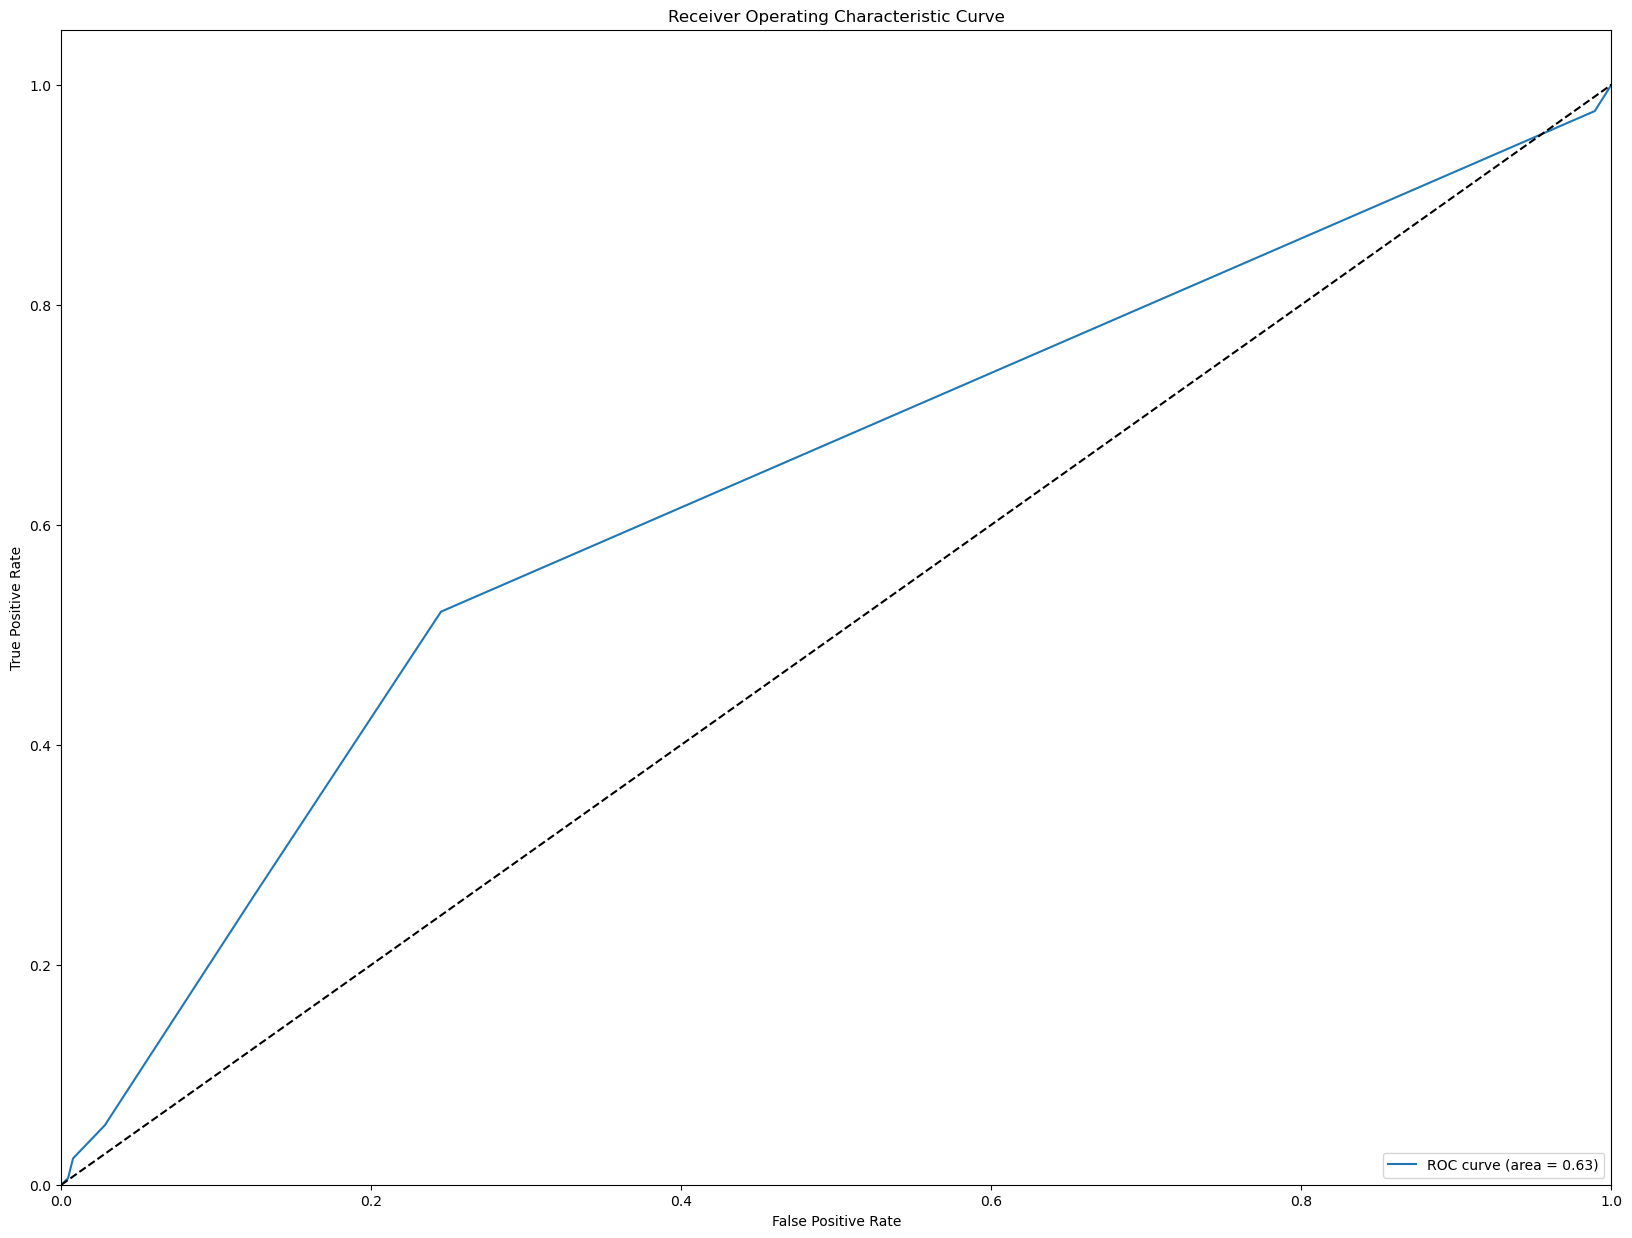

In [89]:
# (c) Out-of-sample ROC plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

The plot indicates that the model has an AUC of 0.63, which, as mentioned before, suggests moderate discriminative ability. The curve itself is plotted alongside a dashed line that represents a no-skill classifier (AUC of 0.5). The actual ROC curve lies above the dashed line, indicating that the model has a better-than-random chance of making a correct prediction.

In [90]:
# (d) Highest achievable TPR for a TNR of at least 60%

# Indices where TNR is at least 60%
tnr_60_indices = np.where(1 - fpr >= 0.60)
max_index = np.max(tnr_60_indices)

# Highest achievable TPR for a TNR of at least 60%
highest_tpr_for_tnr_60 = tpr[max_index]
print(f"Highest achievable TPR for a TNR of at least 60%: {round(highest_tpr_for_tnr_60*100,2)}%")

Highest achievable TPR for a TNR of at least 60%: 52.1%


A note: For a True Negative Rate (TNR) of at least 60%, the maximum attainable True Positive Rate (TPR) is determined. The algorithm finds the matching TPR after determining the highest index at which the False Positive Rate (1 - TNR) is 0.40 or less. The resulting TPR is 52.1%, indicating that 52.1% of the positive cases (1:CHD) are correctly identified when the model is configured to correctly identify at least 60% of the negative cases (0:no CHD). 